<a href="https://colab.research.google.com/github/BoKna031/Image_inpainting/blob/master/Image_inpainting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect to Kaggle dataset

In [1]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
#! kaggle datasets list

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d amanara/photos

Dataset URL: https://www.kaggle.com/datasets/amanara/photos
License(s): unknown
photos.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
!unzip photos.zip;

Archive:  photos.zip
replace Dataset/Testing_Data/Cat-Train (1).png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Data preparation

In [4]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt

TRAIN = 'Train'
TEST = 'Test'

def load_training_dataset(category):
  TRAINING_DATA_FOLDER = os.path.join('Dataset', 'Training_Data', category)
  x_doc = os.path.join('Dataset', 'Training_Data', category, 'Masked_Train')
  x_imgs = _load_images_from_folder(x_doc, category, TRAIN)
  y_doc = os.path.join('Dataset', 'Training_Data', category, 'Unmasked_Train')
  y_imgs = _load_images_from_folder(y_doc, category, TRAIN)
  csv_file = pd.read_csv(os.path.join(TRAINING_DATA_FOLDER, 'masked_info.csv'))
  return x_imgs, y_imgs, csv_file

def _load_images_from_folder(folder, category, set_type):
    images = []
    for filename in os.listdir(folder):
            img = cv2.imread(os.path.join(folder, filename))
            if img is not None:
              id, format = _parse_filename(filename)
              images.append({'filename': filename, 'category': category, 'id': id, 'set_type': set_type, 'format': format, 'image': img})
    images_df = pd.DataFrame(images, columns=['filename', 'category', 'id', 'set_type', 'format', 'image'])
    return images_df

import re

def _parse_filename(filename):
    regex_pattern = r'.*\((\d+)\)\.(\w+)$'

    match = re.match(regex_pattern, filename)

    if match:
        id = int(match.group(1))
        format =  match.group(2)
        return id, format
    else:
        return  None, None

def show_img(img, gray = False):
  if gray:
    plt.imshow(img, 'gray')
  else:
    plt.imshow(img)
  plt.axis('off')
  plt.show()


In [5]:
categories = ['Cat', 'Dog', 'Elephant', 'Tiger']

# Data analyzing

In [6]:
category = categories[0]
x, y, csv = load_training_dataset(category)
x_size = y['image'].apply(lambda img: pd.Series({'rows':img.shape[0], 'cols': img.shape[1]})).groupby(['rows','cols']).size()
print(f"{category}\n---------------------------")
print("total size = ",y.shape[0])
print(x_size)

Cat
---------------------------
total size =  1750
rows  cols
256   256     1750
dtype: int64


From the shown, it can be seen that all the images are of size 256 x 256

In [7]:
csv.head()

,Unnamed: 0,filename,box1_row,box1_col,box2_row,box2_col
0,0,Cat-Train (1085).jpeg,67,6,41,152
1,1,Cat-Train (900).jpeg,86,23,105,165
2,2,Cat-Train (1759).jpeg,60,99,3,140
3,3,Cat-Train (969).jpeg,14,138,47,137
4,4,Cat-Train (1559).jpeg,106,95,41,158


In [8]:
img_size = [256, 256]
box_size = [75, 75]

def is_within_bounds(row, col):
  return row + box_size[0] <= img_size[0] and col + box_size[1] <= img_size[1]

In [9]:
csv['box1_within_bounds'] = csv.apply(lambda row: is_within_bounds(row['box1_row'], row['box1_col']), axis=1)
csv['box2_within_bounds'] = csv.apply(lambda row: is_within_bounds(row['box2_row'], row['box2_col']), axis=1)
invalid_boxes = csv[(~csv['box1_within_bounds']) | (~csv['box2_within_bounds'])]

In [10]:
csv.head()

,Unnamed: 0,filename,box1_row,box1_col,box2_row,box2_col,box1_within_bounds,box2_within_bounds
0,0,Cat-Train (1085).jpeg,67,6,41,152,True,True
1,1,Cat-Train (900).jpeg,86,23,105,165,True,True
2,2,Cat-Train (1759).jpeg,60,99,3,140,True,True
3,3,Cat-Train (969).jpeg,14,138,47,137,True,True
4,4,Cat-Train (1559).jpeg,106,95,41,158,True,True


In [11]:
print(f"There is {invalid_boxes.shape[0]} images that have invalid boxes")

There is 0 images that have invalid boxes


In [12]:
x_cp = y.copy(deep=True)

In [13]:
import numpy as np
def draw_masks(image, csv_row , box_size):
    col1, row1, col2, row2 = csv_row['box1_row'], csv_row['box1_col'], csv_row['box2_row'], csv_row['box2_col']
    mask = np.zeros_like(image)
    cv2.rectangle(mask, (row1, col1), (row1 + box_size[0], col1 + box_size[1]), (255, 255, 255), -1)
    cv2.rectangle(mask, (row2, col2), (row2 + box_size[0], col2 + box_size[1]), (255, 255, 255), -1)
    masked_image = cv2.bitwise_and(image, 255 - mask)
    return masked_image

In [14]:
csv[csv['filename'] == x.iloc[0]['filename']].iloc[0]

Unnamed: 0                            1241
filename              Cat-Train (263).jpeg
box1_row                               153
box1_col                               125
box2_row                               176
box2_col                               178
box1_within_bounds                    True
box2_within_bounds                    True
Name: 1241, dtype: object

In [15]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1750 entries, 0 to 1749
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  1750 non-null   object
 1   category  1750 non-null   object
 2   id        1750 non-null   int64 
 3   set_type  1750 non-null   object
 4   format    1750 non-null   object
 5   image     1750 non-null   object
dtypes: int64(1), object(5)
memory usage: 82.2+ KB


In [16]:
x_cp['image'] = x_cp.apply(lambda row: draw_masks(row['image'], csv[csv['filename'] == row['filename']].iloc[0], box_size), axis = 1)

array([[[12,  7,  6],
        [12,  7,  6],
        [12,  7,  6],
        ...,
        [ 6,  4,  4],
        [ 6,  4,  4],
        [ 6,  4,  4]],

       [[12,  7,  6],
        [12,  7,  6],
        [13,  8,  7],
        ...,
        [ 6,  4,  4],
        [ 6,  4,  4],
        [ 6,  4,  4]],

       [[12,  7,  6],
        [13,  8,  7],
        [13,  8,  7],
        ...,
        [ 6,  4,  4],
        [ 6,  4,  4],
        [ 6,  4,  4]],

       ...,

       [[15,  9, 10],
        [15,  9, 10],
        [15,  9, 10],
        ...,
        [19, 14, 13],
        [19, 14, 13],
        [18, 13, 12]],

       [[15,  9, 10],
        [15,  9, 10],
        [15,  9, 10],
        ...,
        [19, 14, 13],
        [18, 13, 12],
        [18, 13, 12]],

       [[15,  9, 10],
        [15,  9, 10],
        [15,  9, 10],
        ...,
        [19, 14, 13],
        [18, 13, 12],
        [18, 13, 12]]], dtype=uint8)
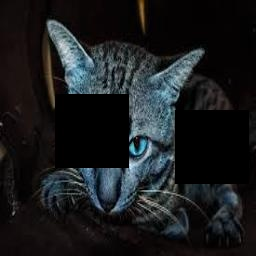

In [17]:
x[x['id']==1014].iloc[0]['image']

array([[[12,  7,  6],
        [12,  7,  6],
        [12,  7,  6],
        ...,
        [ 6,  4,  4],
        [ 6,  4,  4],
        [ 6,  4,  4]],

       [[12,  7,  6],
        [12,  7,  6],
        [13,  8,  7],
        ...,
        [ 6,  4,  4],
        [ 6,  4,  4],
        [ 6,  4,  4]],

       [[12,  7,  6],
        [13,  8,  7],
        [13,  8,  7],
        ...,
        [ 6,  4,  4],
        [ 6,  4,  4],
        [ 6,  4,  4]],

       ...,

       [[15,  9, 10],
        [15,  9, 10],
        [15,  9, 10],
        ...,
        [19, 14, 13],
        [19, 14, 13],
        [18, 13, 12]],

       [[15,  9, 10],
        [15,  9, 10],
        [15,  9, 10],
        ...,
        [19, 14, 13],
        [18, 13, 12],
        [18, 13, 12]],

       [[15,  9, 10],
        [15,  9, 10],
        [15,  9, 10],
        ...,
        [19, 14, 13],
        [18, 13, 12],
        [18, 13, 12]]], dtype=uint8)
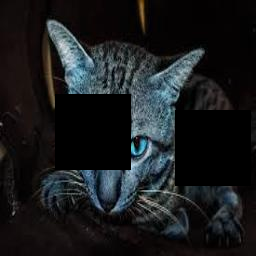

In [18]:
x_cp[x_cp['id']==1014].iloc[0]['image']

In [19]:
x[x['id']==1085]

,filename,category,id,set_type,format,image
1445,Cat-Train (1085).jpeg,Cat,1085,Train,jpeg,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."


In [20]:
x_cp.iloc[0]['filename']

'Cat-Train (263).jpeg'

In [21]:
csv[csv['filename']=='Cat-Train (263).jpeg']

,Unnamed: 0,filename,box1_row,box1_col,box2_row,box2_col,box1_within_bounds,box2_within_bounds
1241,1241,Cat-Train (263).jpeg,153,125,176,178,True,True


In [22]:
merged_df = x_cp.merge(x, on='filename', suffixes=('_cp', '_org'))

# Filtriranje redova gde su vrednosti kolone 'image' različite
merged_df['isSame'] = merged_df.apply(lambda row: np.array_equal(row['image_cp'], row['image_org']), axis=1)

# Brojanje razlika
number_of_differences = len(merged_df[merged_df['isSame']==False])

# Ispis rezultata
print("Broj redova sa različitim vrednostima kolone 'image':", number_of_differences)

Broj redova sa različitim vrednostima kolone 'image': 1750


In [23]:
merged_df.head()

,filename,category_cp,id_cp,set_type_cp,format_cp,image_cp,category_org,id_org,set_type_org,format_org,image_org,isSame
0,Cat-Train (263).jpeg,Cat,263,Train,jpeg,"[[[34, 28, 29], [34, 28, 29], [34, 28, 29], [3...",Cat,263,Train,jpeg,"[[[34, 28, 29], [34, 28, 29], [33, 27, 28], [3...",False
1,Cat-Train (1230).jpeg,Cat,1230,Train,jpeg,"[[[18, 51, 70], [12, 45, 64], [7, 42, 62], [11...",Cat,1230,Train,jpeg,"[[[18, 51, 70], [12, 45, 64], [7, 42, 62], [11...",False
2,Cat-Train (820).jpeg,Cat,820,Train,jpeg,"[[[3, 2, 18], [3, 2, 18], [3, 2, 18], [3, 2, 1...",Cat,820,Train,jpeg,"[[[3, 2, 18], [3, 2, 18], [3, 2, 18], [3, 2, 1...",False
3,Cat-Train (901).jpeg,Cat,901,Train,jpeg,"[[[64, 80, 92], [65, 81, 93], [66, 84, 95], [7...",Cat,901,Train,jpeg,"[[[64, 80, 92], [65, 81, 93], [66, 84, 95], [7...",False
4,Cat-Train (1484).jpeg,Cat,1484,Train,jpeg,"[[[25, 22, 125], [25, 22, 125], [24, 20, 125],...",Cat,1484,Train,jpeg,"[[[25, 22, 125], [25, 22, 125], [24, 20, 125],...",False


In [24]:
type(x_cp.iloc[0]['image'])

numpy.ndarray